In [22]:
import numpy as np
import torch
from nn_solver_PINN_approach import get_mesh_of_sample_space
import math
import matplotlib.pyplot as plt

In [3]:
# Store data from MaierStein_pts.csv into a torch tensor .pt file: 
pts = np.loadtxt('MaierStein_pts.csv', delimiter=',', dtype=float)

# work around the error of inputting numpy data into torch nn
pts_torch = torch.tensor(pts).float()

# save this into the training_data folder: 
torch.save(pts_torch, "./training_data/fem_mesh_points_A_B_removed-True_4224totalpts.pt")



In [7]:
# now we want to store [-1.5,1.5] by [-0.75,0.75] uniform sample of 150*75 points into the training data:
x,y,xx,yy,xx_f,yy_f = get_mesh_of_sample_space(-1.5, 1.5, 150, -0.75, 0.75, 75)
pts = torch.zeros((150*75,2))
pts[:,0] = xx_f
pts[:,1] = yy_f

#save this into training_data folder: 
torch.save(pts, "./training_data/uniformsample11250pts.pt")


402.2857142857143
512.2060797106025
4888


/var/folders/mh/gbj7v0tx7cn3t6x4ypc457mr0000gn/T/ipykernel_6921/1723306517.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


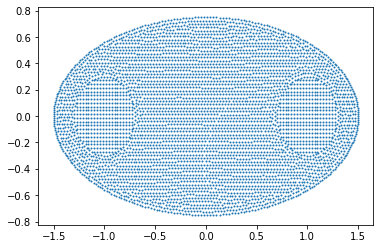

In [21]:
# now we want to make a dataset: ellipse with A and B. Currently we have an ellipse with A and B removed. 
#load ellipse data (A and B removed): 
ellipse_noAB = torch.load("./training_data/fem_mesh_points_A_B_removed-True_4224totalpts.pt")

# find the area of the ellipse: A =  pi * a * b, and we have a = 1.5 and b = 0.75
Area = math.pi * 1.5 * 0.75
# now find the area when removing A and B: 
Area1 = Area - 2* math.pi * (0.3**2)
# now find the density of points: 
density = len(ellipse_noAB) / Area1

# so we should aim for total_pts taken from each of A and B
total_pts = math.pi * 0.3**2 * density
print(total_pts)

# the ratio of the area of a square to a circle circumscribed by that square is more than 1 and precisely: 
ratio = (0.6**2) / (math.pi * (0.3**2))  

# so if we want total_pts taken from A, we need ratio* total_pts taken from the square circumscribing that circle:
sq_pts = ratio * total_pts
print(sq_pts)

sq_pts_x, sq_pts_y = int(math.sqrt(sq_pts)), int(math.sqrt(sq_pts))

# lets generate those square points for A and B: 
x,y,xx,yy,xx_f,yy_f = get_mesh_of_sample_space(-1.3, -0.7, sq_pts_x, -0.3, 0.3, sq_pts_y)
sq_pts_A = torch.zeros((sq_pts_x**2,2))
sq_pts_A[:,0] = xx_f
sq_pts_A[:,1] = yy_f

x,y,xx,yy,xx_f,yy_f = get_mesh_of_sample_space(1.3, 0.7, sq_pts_x, -0.3, 0.3, sq_pts_y)
sq_pts_B = torch.zeros((sq_pts_x**2,2))
sq_pts_B[:,0] = xx_f
sq_pts_B[:,1] = yy_f

# Now we need to remove the stuff outside of A and B: 
indA = [(sq_pts_A[i,0]-1)**2+sq_pts_A[i,1]**2 < 0.3**2 or (sq_pts_A[i,0]+1)**2 + sq_pts_A[i,1]**2 < 0.3**2 for i in range(len(sq_pts_A))]
indB = [(sq_pts_B[i,0]-1)**2+sq_pts_B[i,1]**2 < 0.3**2 or (sq_pts_B[i,0]+1)**2 + sq_pts_B[i,1]**2 < 0.3**2 for i in range(len(sq_pts_B))]

A = sq_pts_A[indA]
B = sq_pts_B[indB]

# fig, ax = plt.subplots()
# ax.scatter(A[:,0], A[:,1], s=1)
# ax.scatter(B[:,0], B[:,1], s=1)
# fig.show()

# now we add A and B to the ellipse: 
ellipse_withAB = torch.cat((ellipse_noAB, A, B))

fig, ax = plt.subplots()
ax.scatter(ellipse_withAB[:,0], ellipse_withAB[:,1], s=1)
fig.show()

print(len(ellipse_withAB))

torch.save(ellipse_withAB, "./training_data/fem_ellipse_with_AB_4888_pts.pt")



/var/folders/mh/gbj7v0tx7cn3t6x4ypc457mr0000gn/T/ipykernel_6921/3595985661.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


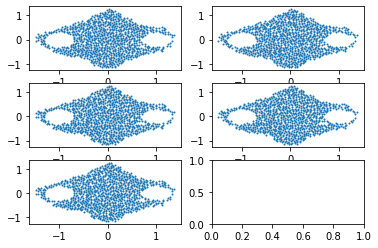

In [27]:
"""
Here we will remove the points in the region A and B including boundary points of A and B. This will be for the PINN approach. 
"""
T_1 = torch.load("./training_data/delta_rarified-num_pts-1110-delta-0.05-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-12.pt")
T_2 = torch.load("./training_data/delta_rarified-num_pts-20038-delta-0.01-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-13.pt")
T_3 = torch.load("./training_data/delta_rarified-num_pts-36597-delta-0.007-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-19.pt")
T_4 = torch.load("./training_data/delta_rarified-num_pts-63173-delta-0.005-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-7-29-11-25.pt")
T_7 = torch.load("./training_data/uniformsample11250pts.pt")

ind1 = [(T_1[i,0]+1)**2 + T_1[i,1]**2 > 0.3**2 and (T_1[i,0]-1)**2 + T_1[i,1]**2 > 0.3**2 for i in range(len(T_1))]
ind2 = [(T_2[i,0]+1)**2 + T_2[i,1]**2 > 0.3**2 and (T_2[i,0]-1)**2 + T_2[i,1]**2 > 0.3**2 for i in range(len(T_2))]
ind3 = [(T_3[i,0]+1)**2 + T_3[i,1]**2 > 0.3**2 and (T_3[i,0]-1)**2 + T_3[i,1]**2 > 0.3**2 for i in range(len(T_3))]
ind4 = [(T_4[i,0]+1)**2 + T_4[i,1]**2 > 0.3**2 and (T_4[i,0]-1)**2 + T_4[i,1]**2 > 0.3**2 for i in range(len(T_4))]
ind5 = [(T_7[i,0]+1)**2 + T_7[i,1]**2 > 0.3**2 and (T_7[i,0]-1)**2 + T_7[i,1]**2 > 0.3**2 for i in range(len(T_7))]

T_1b = T_1[ind1]
T_2b = T_2[ind2]
T_3b = T_3[ind3]
T_4b = T_4[ind4]
T_7b = T_7[ind5]

fig, ax = plt.subplots(3,2)
ax[0,0].scatter(T_1b[:,0].detach(), T_1b[:,1].detach(), s=1)
ax[0,1].scatter(T_1b[:,0].detach(), T_1b[:,1].detach(), s=1)
ax[1,0].scatter(T_1b[:,0].detach(), T_1b[:,1].detach(), s=1)
ax[1,1].scatter(T_1b[:,0].detach(), T_1b[:,1].detach(), s=1)
ax[2,0].scatter(T_1b[:,0].detach(), T_1b[:,1].detach(), s=1)
fig.show()

torch.save(T_1b,f"./training_data/delta_rarified-AB_REMOVEDnum_pts-{len(T_1b)}-delta-0.05-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-12.pt")
torch.save(T_2b, f"./training_data/delta_rarified-AB_REMOVEDnum_pts-{len(T_2b)}-delta-0.01-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-13.pt")
torch.save(T_3b, f"./training_data/delta_rarified-AB_REMOVEDnum_pts-{len(T_3b)}-delta-0.007-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-8-3-16-19.pt")
torch.save(T_4b, f"./training_data/delta_rarified-AB_REMOVEDnum_pts-{len(T_4b)}-delta-0.005-bumps-1000-tau-1000-h_param-0.2-w_param-0.025-deltat-0.001-datetime-2022-7-29-11-25.pt")
torch.save(T_7b, f"./training_data/uniformAB_REMOVEDsample{len(T_7b)}pts.pt")



